## xT de un partido específico

In [ ]:
import pandas as pd
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat

# 1. Load a set of actions to train the model on
SBL = StatsBombLoader()
df_games = SBL.games(competition_id=11, season_id=90)
dataset = [
    {
        **game,
        'actions': spadl.statsbomb.convert_to_actions(
            events=SBL.events(game['game_id']),
            home_team_id=game['home_team_id']
        )
    }
    for game in df_games.to_dict(orient='records')
]

# 2. Convert direction of play + add names
df_actions_ltr = pd.concat([
  spadl.play_left_to_right(game['actions'], game['home_team_id'])
  for game in dataset
])
df_actions_ltr = spadl.add_names(df_actions_ltr)



# 3. Train xT model with 16 x 12 grid
xTModel = xthreat.ExpectedThreat(l=12, w=8)
df_partido = df_actions_ltr[df_actions_ltr["game_id"] == 3773593]
xTModel.fit(df_partido)
xTModel.save_model(filepath='C:\\Users\\Arnau Climent\\OneDrive\\Documentos\\1_MASTER\\PORTFOLIO\\futbol-data-visualizacion\\archivos\\xT\\gridxT.json') #para guardar
#xTModel.fit(df_actions_ltr)

# 4. Rate ball-progressing actions
# xT should only be used to value actions that move the ball
# and that keep the current team in possession of the ball
df_mov_actions = xthreat.get_successful_move_actions(df_partido)
df_mov_actions["xT_value"] = xTModel.rate(df_mov_actions)


c:\Users\Arnau Climent\venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Arnau Climent\venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Arnau Climent\venv\Lib\site-packages\socceraction\data\statsbomb\loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
c:\Users\Arnau Climent\venv\Lib\site-packages\socceraction\data\statsbomb\loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(

# iterations:  60


,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,53.33125,33.9575,43.26875,26.4775,-0.003255
1,dribble,43.26875,26.4775,42.65625,26.9875,0.000000
2,pass,42.65625,26.9875,26.03125,36.2525,0.000418
3,dribble,26.03125,36.2525,32.33125,38.1225,-0.000060
4,pass,32.33125,38.1225,80.10625,8.6275,-0.000063
5,pass,80.63125,8.4575,100.14375,7.3525,-0.001452
6,dribble,100.14375,7.3525,101.63125,8.7975,-0.001174
9,dribble,8.09375,44.8375,10.28125,43.2225,0.001898
10,pass,10.28125,43.2225,9.58125,26.4775,-0.000929
11,dribble,9.58125,26.4775,12.55625,28.2625,0.000000


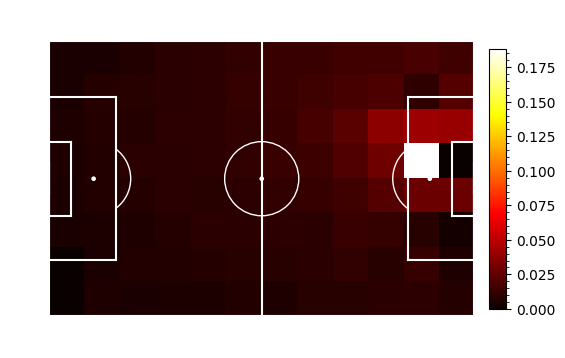

<Axes: >

In [18]:

import matplotsoccer as mps
# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

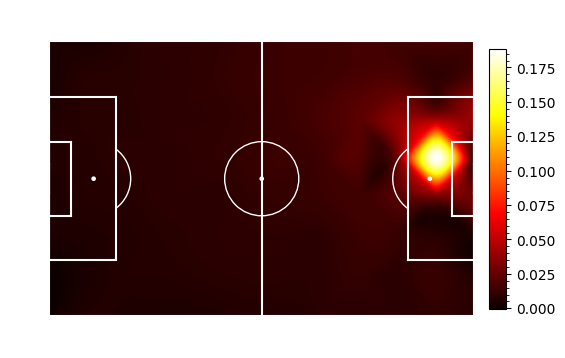

In [19]:
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.xthreat import ExpectedThreat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotsoccer as mps
from scipy.interpolate import CloughTocher2DInterpolator

# Suponiendo que xTModel.xT es una matriz con valores de peligro esperados
xT_values = xTModel.xT

# Definir las coordenadas de la cuadrícula original (basado en el tamaño del campo)
x = np.linspace(0, 105, xT_values.shape[1])  # Longitud del campo
y = np.linspace(0, 68, xT_values.shape[0])   # Anchura del campo

# Crear una malla de puntos
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T  # Convertir la malla en lista de puntos
values = xT_values.ravel()  # Aplanar la matriz de valores

# Crear el interpolador CloughTocher2DInterpolator
interp = CloughTocher2DInterpolator(points, values)

# Definir una malla de puntos más fina para la interpolación
x_fine = np.linspace(0, 105, 1050)
y_fine = np.linspace(0, 68, 680)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

# Aplicar la interpolación
interp_values = interp(X_fine, Y_fine)

# Visualizar el heatmap interpolado
mps.heatmap(interp_values, cmap="hot", linecolor="white", cbar="True")
plt.show()

In [20]:
df_mov_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT_value
0,3773593,831a197f-895a-4a8b-970c-45b722a0752e,1,0.457,222,6402.0,53.33125,33.9575,43.26875,26.4775,0,1,5,0,pass,success,foot_right,-0.003255
1,3773593,8aded538-0e77-444b-88da-2357a275aecd,1,1.644,222,3437.0,43.26875,26.4775,42.65625,26.9875,21,1,0,1,dribble,success,foot,0.000000
2,3773593,1adf165d-2594-4b9a-9fb3-4c62ac161bd6,1,1.994,222,3437.0,42.65625,26.9875,26.03125,36.2525,0,1,5,2,pass,success,foot_right,0.000418
3,3773593,c6f94bd4-1460-45b7-899c-1b2abc147cc9,1,3.780,222,6892.0,26.03125,36.2525,32.33125,38.1225,21,1,0,3,dribble,success,foot,-0.000060
4,3773593,a367100b-1c4b-47aa-8761-3d79315e27ab,1,6.322,222,6892.0,32.33125,38.1225,80.10625,8.6275,0,1,4,4,pass,success,foot_left,-0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,3773593,c986e98c-f544-4b28-bbaf-b83b8739bff5,2,2865.992,222,4629.0,16.84375,26.0525,16.66875,49.3425,0,1,4,2613,pass,success,foot_left,0.000929
2614,3773593,c191be49-fb9e-46ac-8798-5958899f0945,2,2867.505,222,6892.0,16.66875,49.3425,20.86875,50.1925,21,1,0,2614,dribble,success,foot,-0.000067
2616,3773593,7c60da41-c6cb-43ba-889e-6283af798110,2,2869.039,222,6892.0,20.86875,50.1925,50.61875,44.1575,21,1,0,2616,dribble,success,foot,0.003262
2617,3773593,a0c44bdf-cace-449b-9ad6-6d1e8f54354b,2,2875.492,222,6892.0,50.61875,44.1575,78.26875,55.3775,0,1,4,2617,pass,success,foot_left,0.006308


In [ ]:
#agrupar por jugador para entender que jugadores fueron los de más xT.
df_mov_actions_2 = df_mov_actions.groupby('player_id').sum()['xT_value'].sort_values(ascending=False)
df_mov_actions_2

player_id
30756.0    0.624415
5211.0     0.408357
6766.0     0.204689
30486.0    0.165275
5477.0     0.160319
24085.0    0.136392
6379.0     0.089154
11675.0    0.086495
7030.0     0.078102
6826.0     0.063945
6595.0     0.042026
6892.0     0.041785
5487.0     0.040918
6772.0     0.037313
16335.0    0.035210
6590.0     0.031243
5213.0     0.027717
6402.0     0.026817
31090.0    0.023751
6755.0     0.022331
22390.0    0.017297
6771.0     0.007298
4629.0     0.003554
5688.0     0.003097
3437.0     0.002770
5503.0     0.001567
6947.0    -0.003132
3497.0    -0.009207
3501.0    -0.020210
8118.0    -0.108930
5203.0    -0.170171
Name: xT_value, dtype: float64

In [26]:
df_players = SBL.players(game_id=3773593)
df_players

c:\Users\Arnau Climent\venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Arnau Climent\venv\Lib\site-packages\socceraction\data\statsbomb\loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
c:\Users\Arnau Climent\venv\Lib\site-packages\socceraction\data\statsbomb\loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterpress"] = eventsdf["counterpr

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,3773593,222,3437,Francis Joseph Coquelin,None,19,True,15,Left Center Midfield,45
1,3773593,222,3497,Vicente Iborra De La Fuente,Vicente Iborra,10,False,0,Substitute,48
2,3773593,222,4629,José Ramiro Funes Mori,Ramiro Funes Mori,6,False,0,Substitute,10
3,3773593,222,5688,Carlos Arturo Bacca Ahumada,Carlos Bacca,9,False,0,Substitute,10
4,3773593,222,6402,Francisco Alcácer García,Paco Alcácer,17,True,24,Left Center Forward,45
5,3773593,222,6595,Daniel Parejo Muñoz,Dani Parejo,5,True,13,Right Center Midfield,93
6,3773593,222,6755,Sergio Asenjo Andrés,Sergio Asenjo,1,True,1,Goalkeeper,93
7,3773593,222,6766,Gerard Moreno Balaguero,Gerard Moreno,7,True,22,Right Center Forward,83
8,3773593,222,6771,Manuel Trigueros Muñoz,Manu Trigueros,14,False,0,Substitute,48
9,3773593,222,6772,Mario Gaspar Pérez Martínez,Mario Gaspar,2,True,2,Right Back,93


In [32]:
# Unir con df_players para agregar el nombre del jugador
df_mov_actions_2 = df_mov_actions_2.reset_index()  # Restablecer el índice para tener 'player_id' como columna
df_merged = df_mov_actions_2.merge(df_players[['player_id', 'player_name']], on='player_id', how='left')

# Mostrar el DataFrame con los nombres de los jugadores
df_merged

,level_0,index,player_id,xT_value,player_name
0,0,0,30756.0,0.624415,Anssumane Fati
1,1,1,5211.0,0.408357,Jordi Alba Ramos
2,2,2,6766.0,0.204689,Gerard Moreno Balaguero
3,3,3,30486.0,0.165275,Pedro González López
4,4,4,5477.0,0.160319,Ousmane Dembélé
5,5,5,24085.0,0.136392,Pervis Josué Estupiñán Tenorio
6,6,6,6379.0,0.089154,Sergi Roberto Carnicer
7,7,7,11675.0,0.086495,Moisés Gómez Bordonado
8,8,8,7030.0,0.078102,Raúl Albiol i Tortajada
9,9,9,6826.0,0.063945,Clément Lenglet
